In [31]:
import torch

q = torch.distributions.Normal(1, 2)
#sample with reparameterization trick
z = q.rsample()
#print(z)

p = torch.distributions.Normal(0, 1)
#q = torch.distributions.Normal(2, 4)

print(f"z size: {z.size()}")

log_pz = p.log_prob(z)
log_qzx = q.log_prob(z)

print(f"log pz size: {log_pz.size()}")

#print('log prob pz: ', log_pz, 'prob:', torch.exp(log_pz))
#print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

kl_divergence = torch.mean(log_pz - log_qzx, 0)
print(kl_divergence)

z size: torch.Size([])
log pz size: torch.Size([])
tensor(0.8175)


We make use of Variational Inference to approximate the "true" posterior of the latent space $p(z|x)$ with an auxiliary distribution $q(z|x)$ by minimizing the KL Divergence between these two distribution:
$$ D_{KL}(q(z|x)||p(z|x)) = \sum q(z|x) \log \frac{q(z|x)}{p(z|x)} $$

We use a neural network to parameterize $q(z|x)$ such that we can minimize the $D_{KL}$ by training the network. $q(z|x)$ becomes our encoder that outputs the parameter $\theta$ of our distribution $q(z|x) = q_{\theta}(z|x)$. 

Recap the posterior is defined as (Bayes´ Rule):

$$
p(z|x) = \frac{Likelihood * Prior}{Marginal Distribution}=\frac{p(x|z)p(z)}{p(x)}
$$

We can derive the ELBO Loss from $D_{KL}(q(z|x)||p(z|x))$ which will be our overall loss function for our VAE:
\begin{align}
D_{KL}(q(z|x)||p(z|x)) &= \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}\\
&= -\sum q(z|x) \log \frac{p(z|x)}{q(z|x)}\\
&= -\sum q(z|x)  \left[\log p(z|x) - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log \frac{p(x|z)p(z)}{p(x)} - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log p(x|z) + \log p(z) - \log p(x) - \log q(z|x) \right]\\
&= \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log p(x) + \log q(z|x) \right]\\
D_{KL}(q(z|x)||p(z|x)) - \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log q(z|x) \right] &= \log p(x)\\
-\sum q(z|x) \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &= \\
-\mathbb{E}_{z \sim q(z|x)} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
-\mathbb{E}_{q} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
\mathbb{E}_{q} \left[\log p(x|z) - \log \frac{q(z|x)}{p(z)} \right] &=\\
D_{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)\\
D_{KL}(q(z|x)||p(z|x)) + Variational Lower Bound (ELBO) &= \log p(x) \\
ELBO &= \log p(x) - D_{KL}(q(z|x)||p(z|x)) \\
\left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x) - D_{KL}(q(z|x)||p(z|x)) \\
\left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}[ \log q(z|x) - \log p(z)] \right] &= \log p(x) - D_{KL}(q(z|x)||p(z|x)) \\
\left[ \mathbb{E}_{q} \log p(x|z)  - D_{KL}(q(x|z)||p(z)) \right] &= \log p(x) - D_{KL}(q(z|x)||p(z|x))   \leq \log p(x) \\
\end{align}

So if we maximize ELBO this corresponding to maximizing the log probability of generating real data samples $\log p(x)$ (lower bound) which is reduced by the divergence of our "true" and approximate distribution. Maximizing ELBO is same as minizing the negative ELBO:
$$ max(ELBO) = max \left( \mathbb{E}_{q} \log p(x|z)  - D_{KL}(q(x|z)||p(z)) \right) 
             = min \left((D_{KL}(q(x|z)||p(z)) - \mathbb{E}_{q} \log p(x|z) \right) = min(-ELBO) $$

Reconstruction Loss ...

Variational Autoencoder

In [32]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    """
    VAE model
    """
    
    def __init__(self, enc_out_dim = 512, latent_dim = 256, input_height = 32):
        
        super().__init__()
        
        self.save_hyperparameters()

        # encoder q(z|x) => output: distribution param
        self.encoder = resnet18_encoder(False, False)
        
        #decoder p(x|z) => output: sample from high-dim. distribution of input image shape
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
               
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-3)
    
    def kl_divergence(self, z, mu, std):
        """
        Monte Carlo KL Divergence 
        """
        # Standard Gaussian as target distribution p(z)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        # Auxiliary distribution q(x|z)
        q = torch.distributions.Normal(mu, std)
        
        
        # KL Divergence according to our ELBO derivation
        kl = (q.log_prob(z) - p.log_prob(z))
        
        # trick to sum over last dimension as sampling from multivariant gaussian 
        return kl.sum(-1)
    
    def reconstruction_loss(self, x_hat, logscale, x):
        """
        Reconstruction Loss as Regularization
        """
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)
        
        return dist.log_prob(x).sum(dim=(1,2,3))

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.reconstruction_loss(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        }, on_epoch=True)

        return elbo

In [33]:
from pytorch_lightning.callbacks import Callback

class VAEMetricTracker(Callback):

    def __init__(self):
        self.metrics_dict_logs = []

    def on_validation_epoch_end(self, trainer):
        elogs = trainer.logged_metrics
        self.metrics_dict_logs.append(elogs)


In [34]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Root directory for dataset
dataroot = "data/pokemon"

# Batch size during training
batch_size = 24

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [35]:
import warnings
import torch

#clear gpu cache
torch.cuda.empty_cache()

pl.seed_everything(1234)
torch.set_float32_matmul_precision('high')

metric_tracker = VAEMetricTracker()

vae = VAE(input_height = image_size)

Global seed set to 1234
C:\Users\qrno9\AppData\Local\Temp\ipykernel_13768\2891182767.py:23: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
d:\Users\qrno9\miniconda3\envs\pokemon\lib\site-packages\pl_bolts\models\autoencoders\components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
d:\Users\qrno9\minico

In [36]:
from pytorch_lightning.callbacks import ModelSummary
import warnings
import torch

#clear gpu cache
torch.cuda.empty_cache()

pl.seed_everything(1234)
torch.set_float32_matmul_precision('high')

metric_tracker = VAEMetricTracker()

vae = VAE(input_height = image_size)
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=1000, callbacks=[metric_tracker])

#with warnings.catch_warnings('ignore')
trainer.fit(vae, dataloader)

Global seed set to 1234
C:\Users\qrno9\AppData\Local\Temp\ipykernel_13768\2891182767.py:23: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
C:\Users\qrno9\AppData\Local\Temp\ipykernel_13768\2891182767.py:26: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


<Figure size 2400x900 with 0 Axes>

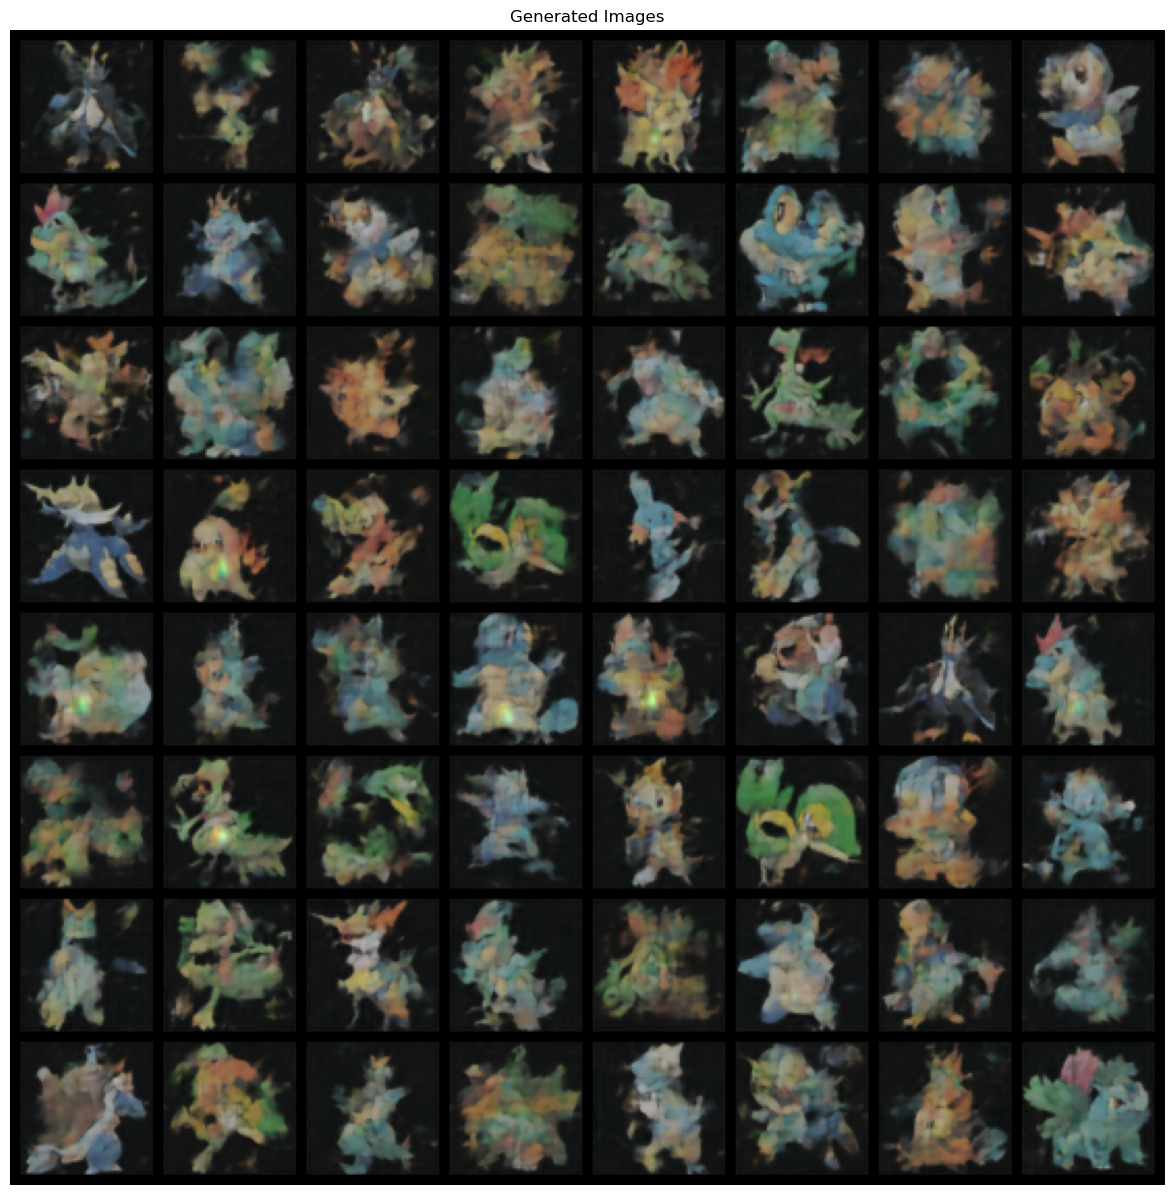

In [49]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
figure(figsize=(8, 3), dpi=300)

# sample latent vector z from multivariant standard gaussian (same distribibution assumed for q/p in training)
num_preds = 64
pl_module = vae
rand_v = torch.rand((num_preds, pl_module.hparams.latent_dim), device=pl_module.device)
p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.ones_like(rand_v))
z = p.rsample()

# generate image given z from VAE decoder
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

plt.figure(figsize=(15,15))
img = make_grid(pred, padding=5, normalize=True).permute(1, 2, 0).numpy()
plt.title("Generated Images")
plt.axis("off")
plt.imshow(img)
plt.show()

T-SNE Plot of (some) pokemon classes (819 in total)

(54,)


d:\Users\qrno9\miniconda3\envs\pokemon\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


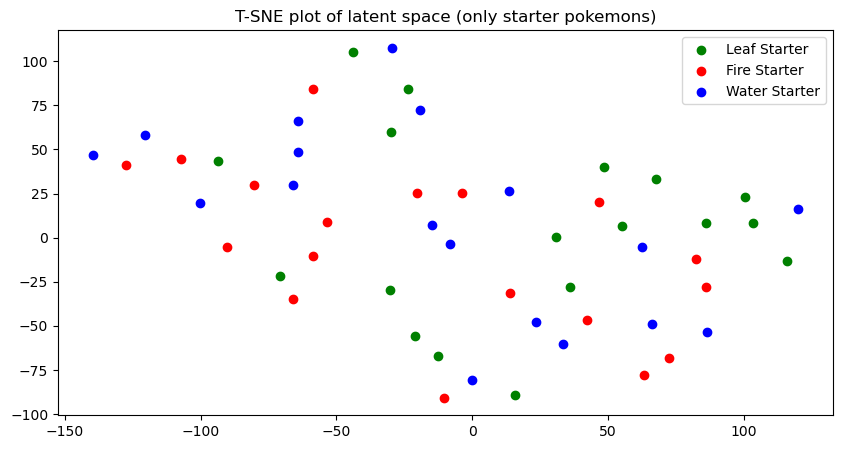

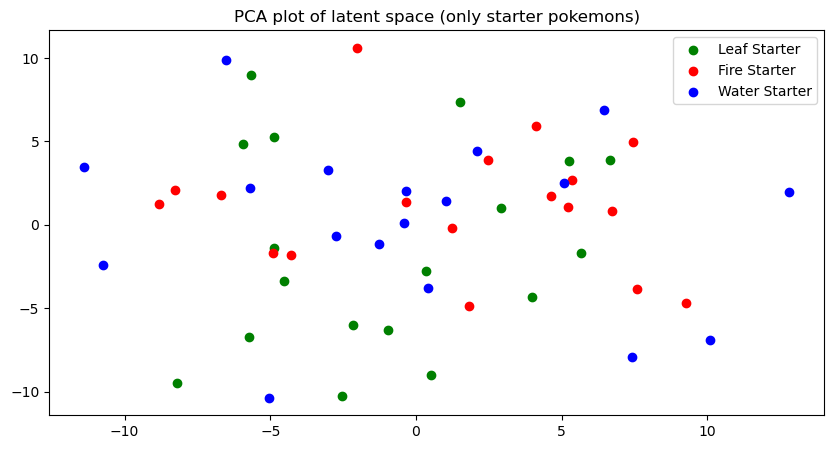

In [50]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=24,
                                         shuffle=False, num_workers=2)

#for all pokemon images
all_images = []
for samples, _ in iter(dataloader):
    all_images.extend(samples)

tensor_images = []

for img in all_images:
    tensor_images.append(img[None, :, :, :])


#print(torch.cat(tensor_images, dim=0).size())

zs = []
for img in tensor_images:
    #feed forward 
    x_encoded = vae.encoder(img)
    mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

    # sample z from q
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    #dim (num_samples, 256)
    zs.append(z.detach().numpy())

    

#concat results
reduced = np.vstack(zs)

all_labels = np.hstack([[0,1,2] for i in range (18)])
print(all_labels.shape)

#dim (num_samples, 2)
reduced_dim = TSNE(n_components=2, perplexity=10, init='random').fit_transform(reduced)

#plot it
plt.figure(figsize=(10,5))

leaf_types = reduced_dim[np.where(all_labels == 0)]
fire_types = reduced_dim[np.where(all_labels == 1)]
water_types = reduced_dim[np.where(all_labels == 2)] 
plt.scatter(leaf_types[:,0], leaf_types[:,1], c="g")
plt.scatter(fire_types[:,0], fire_types[:,1], c="r")
plt.scatter(water_types[:,0], water_types[:,1], c="b")
plt.legend(["Leaf Starter","Fire Starter","Water Starter"])
plt.title("T-SNE plot of latent space (only starter pokemons)")
plt.show()

reduced_dim_pca = PCA(n_components=2).fit_transform(reduced)
plt.figure(figsize=(10,5))

leaf_types_pca = reduced_dim_pca[np.where(all_labels == 0)]
fire_types_pca = reduced_dim_pca[np.where(all_labels == 1)]
water_types_pca = reduced_dim_pca[np.where(all_labels == 2)] 
plt.scatter(leaf_types_pca[:,0], leaf_types_pca[:,1], c="g")
plt.scatter(fire_types_pca[:,0], fire_types_pca[:,1], c="r")
plt.scatter(water_types_pca[:,0], water_types_pca[:,1], c="b")
plt.legend(["Leaf Starter","Fire Starter","Water Starter"])
plt.title("PCA plot of latent space (only starter pokemons)")
plt.show()